<a href="https://colab.research.google.com/github/GustGon/I.A.Python/blob/master/neural-network/nn-recurrent/BOVESPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importação das libs

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
# TensorFlow e tf.keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Imports de biblioteca
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

### Speração dos dados da empresa

In [0]:
#Carregar dataset
dataset = pd.read_csv('/content/drive/My Drive/data-set/BOVESPA.csv',index_col='DATE', parse_dates=['DATE'])
dataset.head()

,CODBDI,CODNEG,DATVEN,FATCOT,NOMRES,PRAZOT,PREABE,PREEXE,PREMAX,PREMED,PREMIN,PREOFC,PREOFV,PREULT,PTOEXE,QUATOT,TOTNEG,TPMERC,VOLTOT
DATE,,,,,,,,,,,,,,,,,,,
1995-01-02,2,ACE 3,99991231,1000,ACESITA,NaN,63.00,0.0,63.00,63.00,63.00,63.0,65.00,63.00,0.0,200000,1,10,12600.0
1995-01-02,2,ACE 4,99991231,1000,ACESITA,NaN,73.00,0.0,73.00,72.71,72.00,71.5,73.00,72.00,0.0,5300000,5,10,385400.0
1995-01-02,2,ALP 4,99991231,1000,ALPARGATAS,NaN,160.00,0.0,165.00,160.03,160.00,156.0,0.00,160.00,0.0,1610000,11,10,257652.0
1995-01-02,2,ROS 4,99991231,1000,AMADEO ROSSI,NaN,1.85,0.0,1.85,1.85,1.85,1.7,1.84,1.85,0.0,300000,1,10,555.0
1995-01-02,2,BAS 4,99991231,1000,AMERICA SUL,NaN,48.00,0.0,48.00,48.00,48.00,0.0,51.50,48.00,0.0,15000,1,10,720.0


In [0]:
dataset.shape

(6394425, 19)

In [0]:
dataset.isnull().sum()

CODBDI          0
CODNEG          0
DATVEN          0
FATCOT          0
NOMRES          4
PRAZOT    3253834
PREABE          0
PREEXE          0
PREMAX          0
PREMED          0
PREMIN          0
PREOFC          0
PREOFV          0
PREULT          0
PTOEXE          0
QUATOT          0
TOTNEG          0
TPMERC          0
VOLTOT          0
dtype: int64

In [0]:
ds_emp = dataset[(dataset['CODNEG'] == 'BRKM5F') & (dataset['CODBDI'] == 96)]
ds_emp.tail()

,CODBDI,CODNEG,DATVEN,FATCOT,NOMRES,PRAZOT,PREABE,PREEXE,PREMAX,PREMED,PREMIN,PREOFC,PREOFV,PREULT,PTOEXE,QUATOT,TOTNEG,TPMERC,VOLTOT
DATE,,,,,,,,,,,,,,,,,,,
2019-09-25,96,BRKM5F,99991231,1,BRASKEM,NaN,32.17,0.0,32.55,32.11,31.78,32.39,32.40,32.40,0.0,7801,383,20,250523.90
2019-09-26,96,BRKM5F,99991231,1,BRASKEM,NaN,32.59,0.0,33.02,32.59,32.20,32.21,32.38,32.38,0.0,9556,520,20,311519.13
2019-09-27,96,BRKM5F,99991231,1,BRASKEM,NaN,32.93,0.0,32.93,32.70,32.43,32.43,32.60,32.43,0.0,8254,448,20,269932.90
2019-09-30,96,BRKM5F,99991231,1,BRASKEM,NaN,32.96,0.0,32.96,32.36,31.92,32.50,32.56,32.56,0.0,9059,516,20,293186.82
2019-10-01,96,BRKM5F,99991231,1,BRASKEM,NaN,32.70,0.0,32.70,32.04,31.52,31.61,31.70,31.70,0.0,9196,585,20,294663.69


### Preparação dos dados

In [0]:
ds_emp = dataset[(dataset['CODNEG'] == 'BRKM5F') & (dataset['CODBDI'] == 96)]
df_filtrado = ds_emp[['CODBDI', 'CODNEG', 'NOMRES', 'PREMAX', 'PREMED', 'PREMIN', 'PREULT', 'VOLTOT']]
df_filtrado.tail()

,CODBDI,CODNEG,NOMRES,PREMAX,PREMED,PREMIN,PREULT,VOLTOT
DATE,,,,,,,,
2019-09-25,96,BRKM5F,BRASKEM,32.55,32.11,31.78,32.40,250523.90
2019-09-26,96,BRKM5F,BRASKEM,33.02,32.59,32.20,32.38,311519.13
2019-09-27,96,BRKM5F,BRASKEM,32.93,32.70,32.43,32.43,269932.90
2019-09-30,96,BRKM5F,BRASKEM,32.96,32.36,31.92,32.56,293186.82
2019-10-01,96,BRKM5F,BRASKEM,32.70,32.04,31.52,31.70,294663.69


In [0]:
df_filtrado.shape

(3958, 8)

In [0]:
df_filtrado.isnull().sum()

CODBDI    0
CODNEG    0
NOMRES    0
PREMAX    0
PREMED    0
PREMIN    0
PREULT    0
VOLTOT    0
dtype: int64

In [0]:
df_filtrado.loc[:,'PREULT'].values

array([310.  , 287.01, 275.01, ...,  32.43,  32.56,  31.7 ])

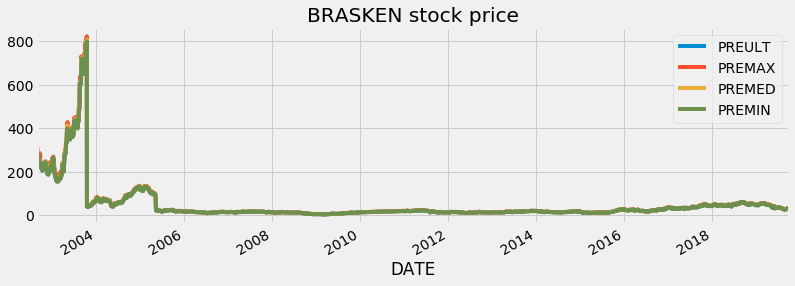

In [0]:
df_filtrado["PREULT"][:].plot(figsize=(12,4),legend=True)
df_filtrado["PREMAX"][:].plot(legend=True)
df_filtrado["PREMED"][:].plot(legend=True)
df_filtrado["PREMIN"][:].plot(legend=True)
plt.legend(['PREULT','PREMAX','PREMED','PREMIN'])
plt.title('BRASKEN stock price')
plt.show()

### Teste utilizando PREULT

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].loc[:,'PREULT'].values
test_set = df_filtrado['2018':'2019'].loc[:,'PREULT'].values
val_set = df_filtrado['2019':].loc[:,'PREULT'].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)

In [0]:
training_set_norm.shape

(3542, 1)

In [0]:
X_train = []
y_train = []
n_steps = 200
for i in range (n_steps, training_set_norm.shape[0]):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i, 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(3342,)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(3342, 200, 1)

X_train( n samples, n steps, n features )

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=10, return_sequences=True, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=10))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=50,batch_size=32)

Train on 3342 samples
Epoch 1/50
3342/3342 [==============================] - 11s 3ms/sample - loss: 0.0051 - mse: 0.0051 - mae: 0.0239
Epoch 2/50
3342/3342 [==============================] - 3s 882us/sample - loss: 0.0036 - mse: 0.0036 - mae: 0.0197
Epoch 3/50
3342/3342 [==============================] - 3s 877us/sample - loss: 0.0029 - mse: 0.0029 - mae: 0.0181
Epoch 4/50
3342/3342 [==============================] - 3s 865us/sample - loss: 0.0029 - mse: 0.0029 - mae: 0.0180
Epoch 5/50
3342/3342 [==============================] - 3s 874us/sample - loss: 0.0029 - mse: 0.0029 - mae: 0.0178
Epoch 6/50
3342/3342 [==============================] - 3s 874us/sample - loss: 0.0028 - mse: 0.0028 - mae: 0.0168
Epoch 7/50
3342/3342 [==============================] - 3s 874us/sample - loss: 0.0025 - mse: 0.0025 - mae: 0.0164
Epoch 8/50
3342/3342 [==============================] - 3s 869us/sample - loss: 0.0025 - mse: 0.0025 - mae: 0.0166
Epoch 9/50
3342/3342 [==============================] - 3s 

DropOut - Retira x% dos numeros de neuronios para nao viciar os pessos.

Return sequences apenas de rede recorrente para rede recorrente.

Optimizer mais usados - rmsprop e xxxxxxx

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

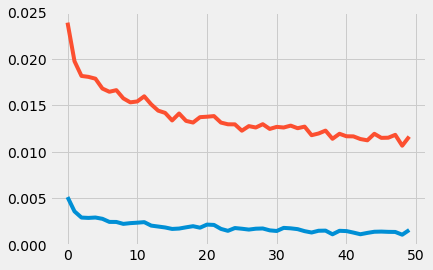

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

Dicas sobre a convergencia do algoritimo.

Learning Rate; Decaimento; numero de epocas

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREULT'][:'2017'],df_filtrado['PREULT']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.47059995],
       [0.4718878 ],
       [0.47396246],
       [0.47731537],
       [0.4854742 ],
       [0.49761894],
       [0.51217264],
       [0.52514833],
       [0.53694475],
       [0.54739636]], dtype=float32)

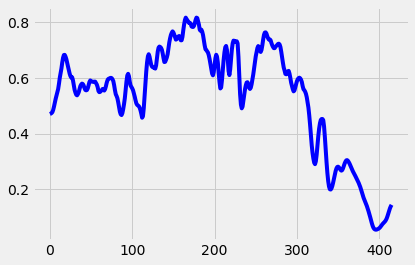

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

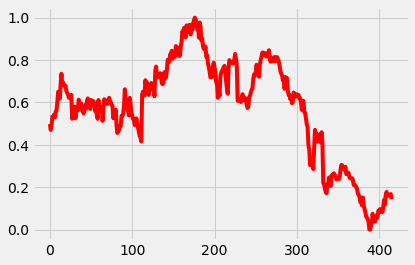

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

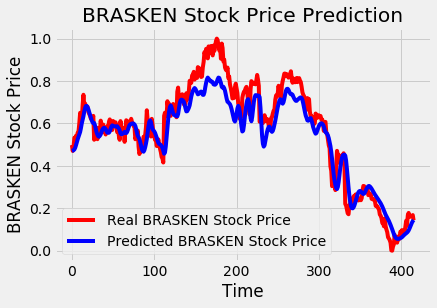

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()

### Teste com PREMED

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].loc[:,'PREMED'].values
test_set = df_filtrado['2018':'2019'].loc[:,'PREMED'].values
val_set = df_filtrado['2019':].loc[:,'PREMED'].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)

In [0]:
training_set_norm.shape

(3542, 1)

In [0]:
X_train = []
y_train = []
n_steps = 30
for i in range (n_steps, training_set_norm.shape[0]):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i, 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(3512,)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(3512, 30, 1)

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=10, return_sequences=True, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=10))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=100,batch_size=32)

Train on 3512 samples
Epoch 1/100
3512/3512 [==============================] - 6s 2ms/sample - loss: 0.0098 - mse: 0.0098 - mae: 0.0393
Epoch 2/100
3512/3512 [==============================] - 1s 361us/sample - loss: 0.0046 - mse: 0.0046 - mae: 0.0246
Epoch 3/100
3512/3512 [==============================] - 1s 366us/sample - loss: 0.0038 - mse: 0.0038 - mae: 0.0227
Epoch 4/100
3512/3512 [==============================] - 1s 368us/sample - loss: 0.0033 - mse: 0.0033 - mae: 0.0215
Epoch 5/100
3512/3512 [==============================] - 1s 364us/sample - loss: 0.0036 - mse: 0.0036 - mae: 0.0216
Epoch 6/100
3512/3512 [==============================] - 1s 363us/sample - loss: 0.0035 - mse: 0.0035 - mae: 0.0219
Epoch 7/100
3512/3512 [==============================] - 1s 373us/sample - loss: 0.0034 - mse: 0.0034 - mae: 0.0213
Epoch 8/100
3512/3512 [==============================] - 1s 369us/sample - loss: 0.0030 - mse: 0.0030 - mae: 0.0210
Epoch 9/100
3512/3512 [=============================

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

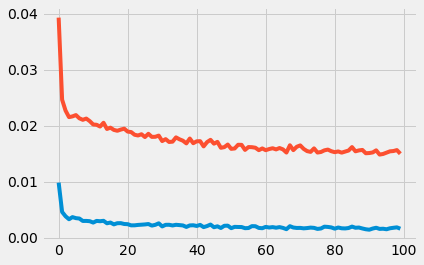

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREMED'][:'2017'],df_filtrado['PREMED']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.48208702],
       [0.4855657 ],
       [0.49069247],
       [0.4952606 ],
       [0.50375473],
       [0.51683646],
       [0.53396857],
       [0.5479118 ],
       [0.55829924],
       [0.5689885 ]], dtype=float32)

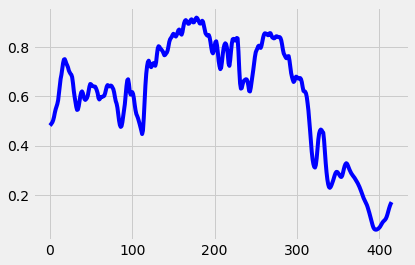

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

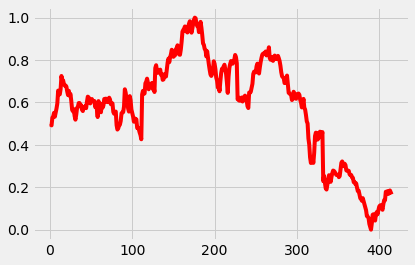

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

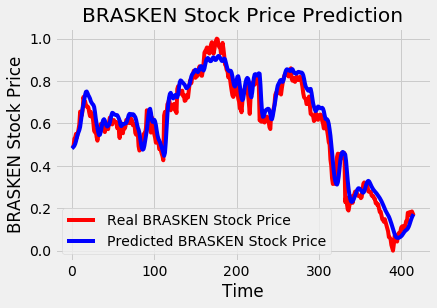

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()

### Teste com Step em 5 valores para frente

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].loc[:,'PREMED'].values
test_set = df_filtrado['2018':'2019'].loc[:,'PREMED'].values
val_set = df_filtrado['2019':].loc[:,'PREMED'].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)

In [0]:
training_set_norm.shape

(3542, 1)

In [0]:
X_train = []
y_train = []
n_steps = 30
step = 5
for i in range (n_steps, training_set_norm.shape[0] - step ):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i:(i + step), 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(3507, 5)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(3507, 30, 1)

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=10, return_sequences=True, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=10))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=step))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=100,batch_size=32)

Train on 3507 samples
Epoch 1/100
3507/3507 [==============================] - 7s 2ms/sample - loss: 0.0083 - mse: 0.0083 - mae: 0.0346
Epoch 2/100
3507/3507 [==============================] - 1s 367us/sample - loss: 0.0056 - mse: 0.0056 - mae: 0.0263
Epoch 3/100
3507/3507 [==============================] - 1s 369us/sample - loss: 0.0051 - mse: 0.0051 - mae: 0.0258
Epoch 4/100
3507/3507 [==============================] - 1s 377us/sample - loss: 0.0049 - mse: 0.0049 - mae: 0.0258
Epoch 5/100
3507/3507 [==============================] - 1s 366us/sample - loss: 0.0039 - mse: 0.0039 - mae: 0.0240
Epoch 6/100
3507/3507 [==============================] - 1s 370us/sample - loss: 0.0038 - mse: 0.0038 - mae: 0.0240
Epoch 7/100
3507/3507 [==============================] - 1s 359us/sample - loss: 0.0038 - mse: 0.0038 - mae: 0.0236
Epoch 8/100
3507/3507 [==============================] - 1s 363us/sample - loss: 0.0040 - mse: 0.0040 - mae: 0.0233
Epoch 9/100
3507/3507 [=============================

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

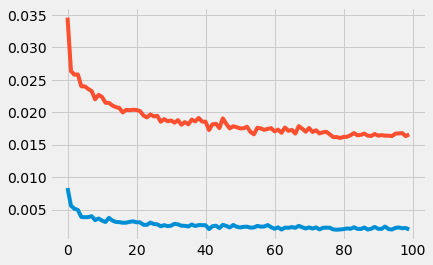

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREMED'][:'2017'],df_filtrado['PREMED']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.4715634 , 0.47811237, 0.47252923, 0.47152016, 0.47339883],
       [0.4694556 , 0.47597978, 0.47041076, 0.4693561 , 0.47132427],
       [0.4698099 , 0.4763585 , 0.47076982, 0.46959448, 0.47176826],
       [0.4714457 , 0.47805327, 0.47243804, 0.47111395, 0.47354522],
       [0.477873  , 0.48462078, 0.4788952 , 0.47734156, 0.48012167],
       [0.48879346, 0.49573117, 0.48981366, 0.4879823 , 0.4911536 ],
       [0.5036731 , 0.51082146, 0.50463086, 0.5025289 , 0.5060464 ],
       [0.5174646 , 0.5247666 , 0.51832604, 0.51608443, 0.51975924],
       [0.5299917 , 0.53739715, 0.53072184, 0.5284786 , 0.5320968 ],
       [0.5430041 , 0.5505015 , 0.5435711 , 0.54139376, 0.5448295 ]],
      dtype=float32)

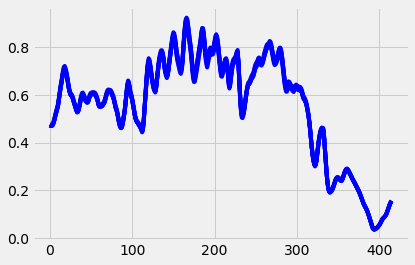

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

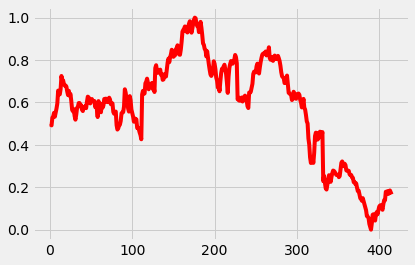

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

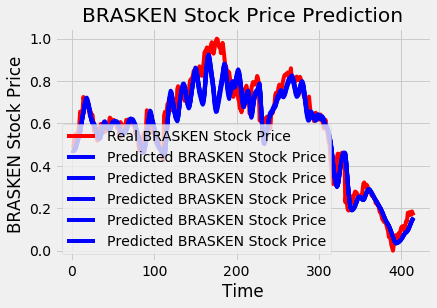

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()

### Teste com Step em 3 valores para frente

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].loc[:,'PREMED'].values
test_set = df_filtrado['2018':'2019'].loc[:,'PREMED'].values
val_set = df_filtrado['2019':].loc[:,'PREMED'].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)

In [0]:
training_set_norm.shape

(3542, 1)

In [0]:
X_train = []
y_train = []
n_steps = 30
step = 3
for i in range (n_steps, training_set_norm.shape[0] - step ):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i:(i + step), 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(3509, 3)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(3509, 30, 1)

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=10, return_sequences=True, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=10))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=step))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=100,batch_size=32)

Train on 3509 samples
Epoch 1/100
3509/3509 [==============================] - 6s 2ms/sample - loss: 0.0078 - mse: 0.0078 - mae: 0.0332
Epoch 2/100
3509/3509 [==============================] - 1s 364us/sample - loss: 0.0052 - mse: 0.0052 - mae: 0.0269
Epoch 3/100
3509/3509 [==============================] - 1s 370us/sample - loss: 0.0055 - mse: 0.0055 - mae: 0.0262
Epoch 4/100
3509/3509 [==============================] - 1s 359us/sample - loss: 0.0048 - mse: 0.0048 - mae: 0.0255
Epoch 5/100
3509/3509 [==============================] - 1s 370us/sample - loss: 0.0042 - mse: 0.0042 - mae: 0.0245
Epoch 6/100
3509/3509 [==============================] - 1s 366us/sample - loss: 0.0038 - mse: 0.0038 - mae: 0.0233
Epoch 7/100
3509/3509 [==============================] - 1s 364us/sample - loss: 0.0036 - mse: 0.0036 - mae: 0.0222
Epoch 8/100
3509/3509 [==============================] - 1s 366us/sample - loss: 0.0034 - mse: 0.0034 - mae: 0.0219
Epoch 9/100
3509/3509 [=============================

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

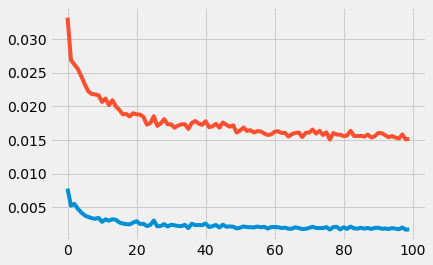

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREMED'][:'2017'],df_filtrado['PREMED']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.4428065 , 0.44327518, 0.43969592],
       [0.44499052, 0.44545153, 0.44185415],
       [0.44819653, 0.44866493, 0.44503412],
       [0.450127  , 0.45061317, 0.44694084],
       [0.45855567, 0.4590787 , 0.4553295 ],
       [0.47185203, 0.4724322 , 0.46854421],
       [0.48802322, 0.48868042, 0.48460189],
       [0.49683338, 0.49756932, 0.49330202],
       [0.5026072 , 0.50341713, 0.49900582],
       [0.5119523 , 0.51282954, 0.5082945 ]], dtype=float32)

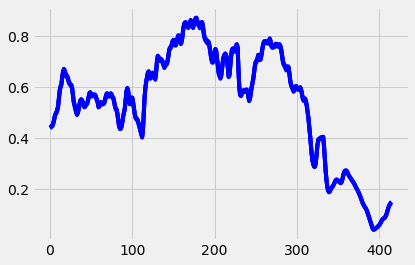

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

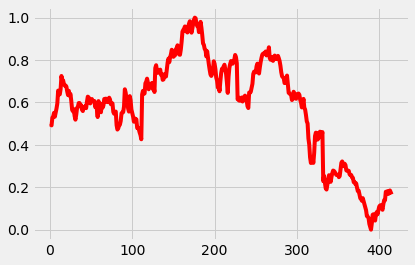

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

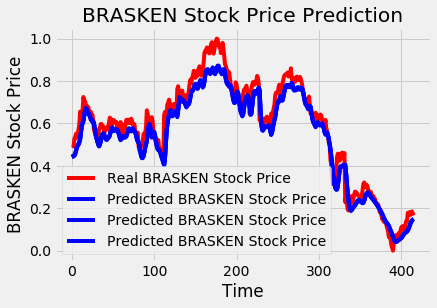

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()

### Teste com GRU

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].loc[:,'PREMED'].values
test_set = df_filtrado['2018':'2019'].loc[:,'PREMED'].values
val_set = df_filtrado['2019':].loc[:,'PREMED'].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)

In [0]:
training_set_norm.shape

(3542, 1)

In [0]:
X_train = []
y_train = []
n_steps = 30
step = 3
for i in range (n_steps, training_set_norm.shape[0] - step ):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i:(i + step), 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(3509, 3)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(3509, 30, 1)

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(GRU(units=10, return_sequences=True, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(GRU(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(GRU(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(GRU(units=10))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=step))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=100,batch_size=32)

Train on 3509 samples
Epoch 1/100
3509/3509 [==============================] - 6s 2ms/sample - loss: 0.0083 - mse: 0.0083 - mae: 0.0362
Epoch 2/100
3509/3509 [==============================] - 1s 339us/sample - loss: 0.0046 - mse: 0.0046 - mae: 0.0275
Epoch 3/100
3509/3509 [==============================] - 1s 341us/sample - loss: 0.0039 - mse: 0.0039 - mae: 0.0253
Epoch 4/100
3509/3509 [==============================] - 1s 348us/sample - loss: 0.0036 - mse: 0.0036 - mae: 0.0245
Epoch 5/100
3509/3509 [==============================] - 1s 341us/sample - loss: 0.0032 - mse: 0.0032 - mae: 0.0236
Epoch 6/100
3509/3509 [==============================] - 1s 341us/sample - loss: 0.0031 - mse: 0.0031 - mae: 0.0225
Epoch 7/100
3509/3509 [==============================] - 1s 337us/sample - loss: 0.0031 - mse: 0.0031 - mae: 0.0226
Epoch 8/100
3509/3509 [==============================] - 1s 341us/sample - loss: 0.0028 - mse: 0.0028 - mae: 0.0217
Epoch 9/100
3509/3509 [=============================

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

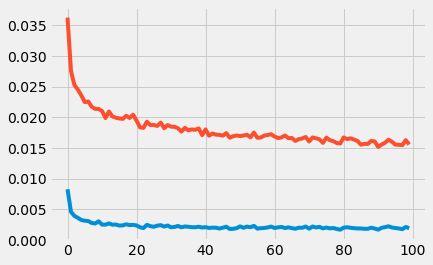

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREULT'][:'2017'],df_filtrado['PREULT']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.5344254 , 0.5152881 , 0.5329386 ],
       [0.53734624, 0.51829743, 0.53599566],
       [0.5365142 , 0.51749843, 0.5351947 ],
       [0.53880584, 0.5198277 , 0.5375707 ],
       [0.5514803 , 0.5325278 , 0.5505603 ],
       [0.56352407, 0.5445014 , 0.5628514 ],
       [0.57416695, 0.5550216 , 0.573647  ],
       [0.5789913 , 0.5596802 , 0.5784265 ],
       [0.5875489 , 0.5681119 , 0.58702534],
       [0.5966824 , 0.5770979 , 0.59620506]], dtype=float32)

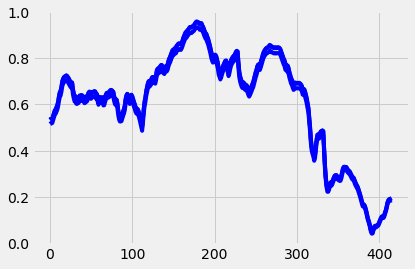

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

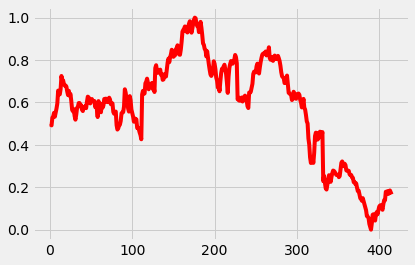

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

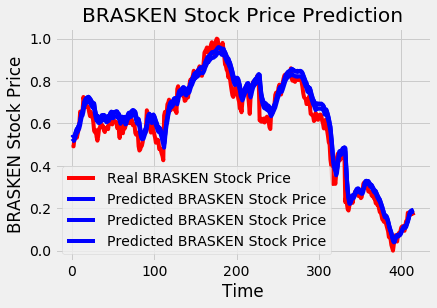

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()

### Teste com PREMED e PREULT

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].iloc[:,[4,6]].values #'PREMED'and 'PREULT'
test_set = df_filtrado['2018':'2019'].iloc[:,[4,6]].values
val_set = df_filtrado['2019':].iloc[:,[4,6]].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)

In [0]:
training_set_norm.shape

(7084, 1)

In [0]:
X_train = []
y_train = []
n_steps = 30
step = 3
for i in range (n_steps, training_set_norm.shape[0] - step ):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i:(i + step), 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(7051, 3)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(7051, 30, 1)

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(GRU(units=80, return_sequences=True, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(GRU(units=80, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(GRU(units=80, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(GRU(units=80))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=step))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=100,batch_size=32)

Train on 7051 samples
Epoch 1/100
7051/7051 [==============================] - 8s 1ms/sample - loss: 0.0027 - mse: 0.0027 - mae: 0.0256
Epoch 2/100
7051/7051 [==============================] - 2s 335us/sample - loss: 0.0020 - mse: 0.0020 - mae: 0.0216
Epoch 3/100
7051/7051 [==============================] - 2s 344us/sample - loss: 0.0019 - mse: 0.0019 - mae: 0.0206
Epoch 4/100
7051/7051 [==============================] - 2s 350us/sample - loss: 0.0019 - mse: 0.0019 - mae: 0.0202
Epoch 5/100
7051/7051 [==============================] - 2s 346us/sample - loss: 0.0018 - mse: 0.0018 - mae: 0.0199
Epoch 6/100
7051/7051 [==============================] - 2s 345us/sample - loss: 0.0018 - mse: 0.0018 - mae: 0.0193
Epoch 7/100
7051/7051 [==============================] - 2s 336us/sample - loss: 0.0019 - mse: 0.0019 - mae: 0.0192
Epoch 8/100
7051/7051 [==============================] - 2s 332us/sample - loss: 0.0016 - mse: 0.0016 - mae: 0.0183
Epoch 9/100
7051/7051 [=============================

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

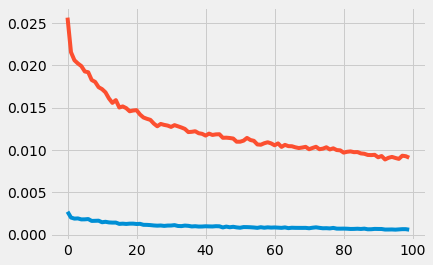

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREULT'][:'2017'], df_filtrado['PREMED'][:'2017'], df_filtrado['PREULT']['2018':'2019'], df_filtrado['PREMED']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.5830189 , 0.59314287, 0.54423594],
       [0.5726501 , 0.5525401 , 0.51954335],
       [0.55037135, 0.5605465 , 0.5078857 ],
       [0.5706532 , 0.5238793 , 0.49467126],
       [0.54189956, 0.5186429 , 0.4934205 ],
       [0.5694821 , 0.53061754, 0.50170976],
       [0.5337494 , 0.50180477, 0.4928965 ],
       [0.56672096, 0.5644262 , 0.5319302 ],
       [0.5512837 , 0.5164203 , 0.4960426 ],
       [0.5793008 , 0.5763871 , 0.53829944]], dtype=float32)

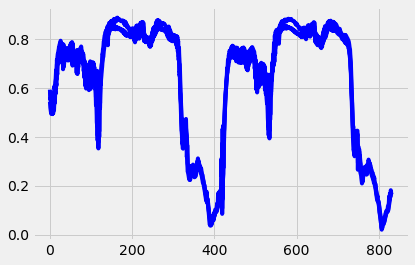

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

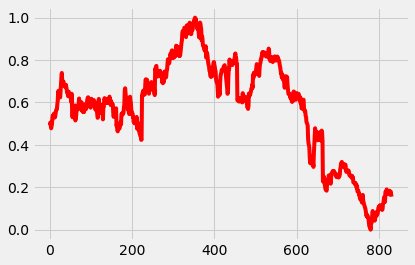

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

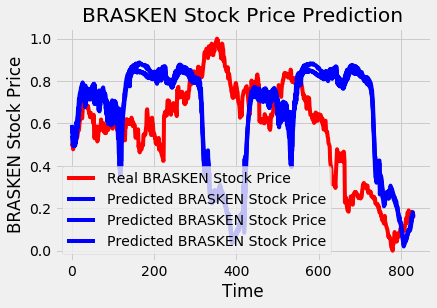

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()

### Teste de Encod-Decod

In [0]:
#Separando treino de teste
training_set = df_filtrado[:'2017'].loc[:,'PREMED'].values
test_set = df_filtrado['2018':'2019'].loc[:,'PREMED'].values
val_set = df_filtrado['2019':].loc[:,'PREMED'].values

In [0]:
#Normalizar os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
test_set = test_set.reshape(-1,1)
val_set = val_set.reshape(-1,1)
training_set_norm = sc.fit_transform(training_set)
test_set_norm = sc.fit_transform(test_set)
val_set_norm = sc.fit_transform(val_set)

In [0]:
training_set_norm.shape

(3542, 1)

In [0]:
X_train = []
y_train = []
n_steps = 30
step = 1
for i in range (n_steps, training_set_norm.shape[0] - step ):
  X_train.append( training_set_norm[ i-n_steps:i, 0 ] )
  y_train.append( training_set_norm[ i:(i + step), 0 ])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
y_train.shape

(3511, 1)

In [0]:
#Reshaping os valores de X
X_train_3D = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
X_train_3D.shape

(3511, 30, 1)

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=80, return_sequences=False, input_shape=(X_train_3D.shape[1], 1)))
regressor.add(Dropout(0.2))
# Lambda layer
#regressor.add(Lambda(lambda x: ) 
# RepeatVector Layer
regressor.add(RepeatVector(10))
# Lambda layer
#regressor.add(Lambda(lambda x: )
# Third LSTM layer
#regressor.add(LSTM(units=80, return_sequences=True))
#regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=80))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=step))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(X_train_3D,y_train,epochs=80,batch_size=32)

Train on 3511 samples
Epoch 1/80
3511/3511 [==============================] - 4s 1ms/sample - loss: 0.0025 - mse: 0.0025 - mae: 0.0205
Epoch 2/80
3511/3511 [==============================] - 1s 222us/sample - loss: 0.0018 - mse: 0.0018 - mae: 0.0173
Epoch 3/80
3511/3511 [==============================] - 1s 227us/sample - loss: 0.0018 - mse: 0.0018 - mae: 0.0168
Epoch 4/80
3511/3511 [==============================] - 1s 226us/sample - loss: 0.0017 - mse: 0.0017 - mae: 0.0162
Epoch 5/80
3511/3511 [==============================] - 1s 226us/sample - loss: 0.0017 - mse: 0.0017 - mae: 0.0165
Epoch 6/80
3511/3511 [==============================] - 1s 226us/sample - loss: 0.0017 - mse: 0.0017 - mae: 0.0163
Epoch 7/80
3511/3511 [==============================] - 1s 225us/sample - loss: 0.0017 - mse: 0.0017 - mae: 0.0164
Epoch 8/80
3511/3511 [==============================] - 1s 223us/sample - loss: 0.0015 - mse: 0.0015 - mae: 0.0156
Epoch 9/80
3511/3511 [==============================] - 1s 2

In [0]:
historico.history.keys()

dict_keys(['loss', 'mse', 'mae'])

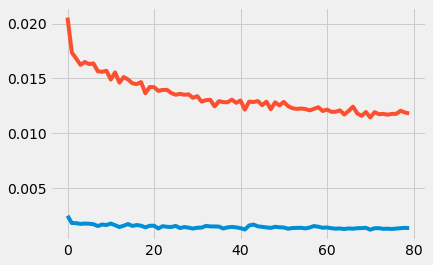

In [0]:
plt.plot( historico.history['mse'] )
plt.plot( historico.history['mae'] )

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREMED'][:'2017'],df_filtrado['PREMED']['2018':'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(test_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_test = []
for i in range(n_steps,inputs.shape[0]):
    X_test.append( inputs[ i-n_steps:i, 0 ] )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_test)

In [0]:
predicted_stock_price[:10]

array([[0.5143711 ],
       [0.50572646],
       [0.5149989 ],
       [0.5192395 ],
       [0.51891166],
       [0.54240936],
       [0.5588844 ],
       [0.57755154],
       [0.5718362 ],
       [0.5799917 ]], dtype=float32)

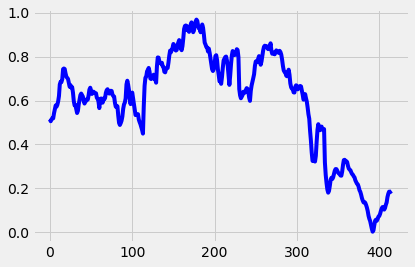

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

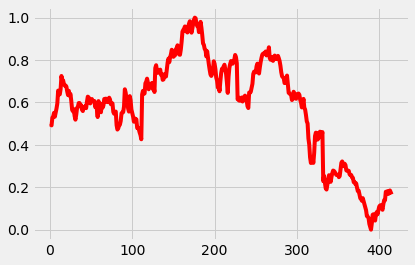

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')

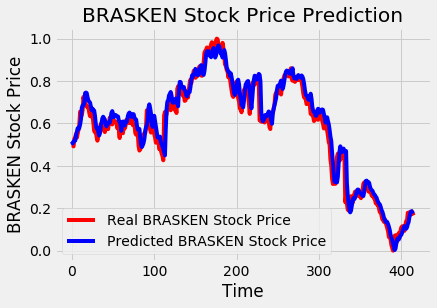

In [0]:
plt.plot(test_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()

In [0]:
#Vamos testar com os dados de teste, lembrando que os valores de testes são também os resultados
#Para a primeira previsão com os dados de teste precisamos pegar 60 valores anteriores, só que para isso precisamos de todo dataset
dataset_total = pd.concat((df_filtrado['PREMED'][:'2017'], df_filtrado['PREMED'][:'2019']),axis=0)
inputs = dataset_total[ len(dataset_total)-len(val_set) - n_steps: ].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
#Preparando X de teste para prever as ações
X_val = []
for i in range(n_steps, inputs.shape[0]):
    X_val.append( inputs[ i-n_steps:i, 0 ] )
X_val = np.array(X_val)
X_val = np.reshape(X_val, (X_val.shape[0],X_val.shape[1],1))

In [0]:
predicted_stock_price = regressor.predict(X_val)

In [0]:
predicted_stock_price[:10]

array([[0.82966846],
       [0.79766643],
       [0.65210044],
       [0.6232502 ],
       [0.6102065 ],
       [0.61719024],
       [0.62475467],
       [0.63993084],
       [0.63411367],
       [0.63674206]], dtype=float32)

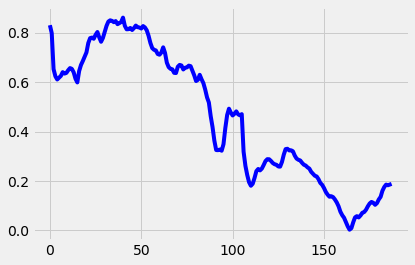

In [0]:
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')

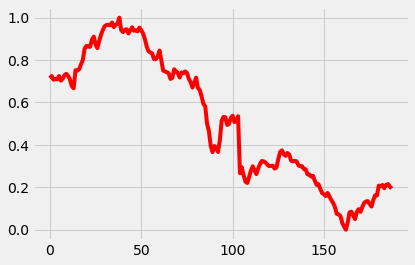

In [0]:
plt.plot(val_set_norm, color='red',label='Real BRASKEN Stock Price')

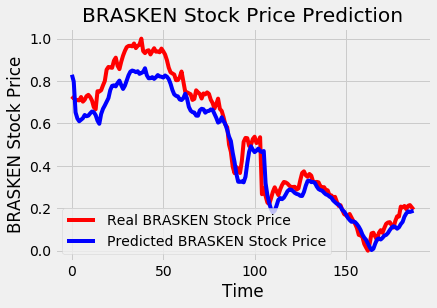

In [0]:
plt.plot(val_set_norm, color='red',label='Real BRASKEN Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted BRASKEN Stock Price')
plt.title('BRASKEN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BRASKEN Stock Price')
plt.legend()
plt.show()